In [1]:
git_dir = '/mnt/c/Users/ArcaroLab/Desktop/git_repos/dhcp'

import os
import sys
#add git_dir to path
sys.path.append(git_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params

from sklearn.manifold import MDS

In [2]:
atlas = 'wang'

infant_dir = '/mnt/e/dhcp_analysis_full'
adult_dir = '/mnt/f/7T_HCP'

#load atlast name and roi labels
atlas_name, roi_labels = params.load_roi_info(atlas)

#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
roi_labels['network'] = ['EVC']*7 + ['ventral']*4 + ['lateral']*6 + ['dorsal']*8

networks = ['EVC', 'ventral', 'lateral', 'dorsal']
network_colors = ['k', 'r', 'b', 'g']

#expand roi labels to include hemis
all_labels = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_labels.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




In [7]:
def compute_group_fc(sub_list, data_dir, atlas):
    n =0
    for sub in sub_list['participant_id']:

        #check if file exists
        if not os.path.exists(f'{data_dir}/{sub}_{atlas}_fc.npy'):
            print(f'{sub} does not exist')
            continue
        #load fc matrix
        fc_mat = np.load(f'{data_dir}/{sub}_{atlas}_fc.npy')
        fc_mat = np.round(fc_mat, 4)

    

        if n == 0:
            mean_fc = fc_mat
        else:
            mean_fc = mean_fc + fc_mat

        n = n + 1

    #divide by number of subjects
    mean_fc = mean_fc / len(sub_list)

    return mean_fc

In [11]:
def plot_fc_matrix(corr_mat, roi_labels):
    #make diagonal to nans
    corr_mat = np.array(corr_mat)
    #corr_mat = np.fill_diagonal(corr_mat, np.nan)


    sns.heatmap(corr_mat, cmap= 'viridis')
    #make bigger 
    plt.gcf().set_size_inches(15,15)

    #add labels from all_labels
    plt.xticks(np.arange(0.5, len(all_labels), 1), all_labels, rotation = 90);
    plt.yticks(np.arange(0.5, len(all_labels), 1), all_labels, rotation = 0);
    #make background black
    ax = plt.gca()
    ax.set_facecolor('black')

    plt.show()
    plt.pause(.001)


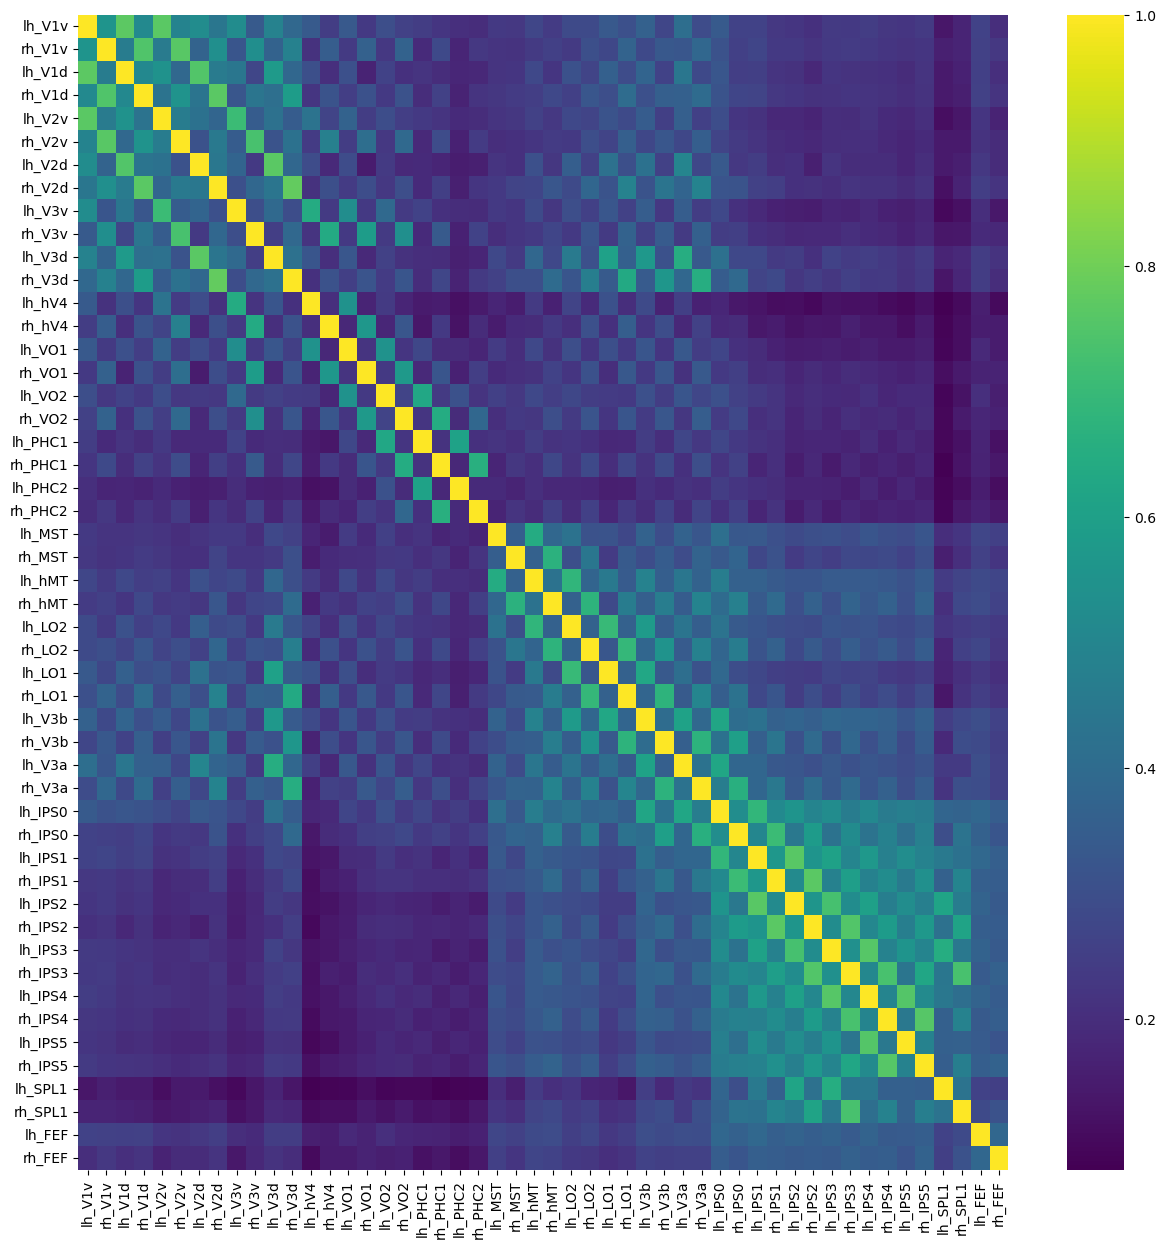

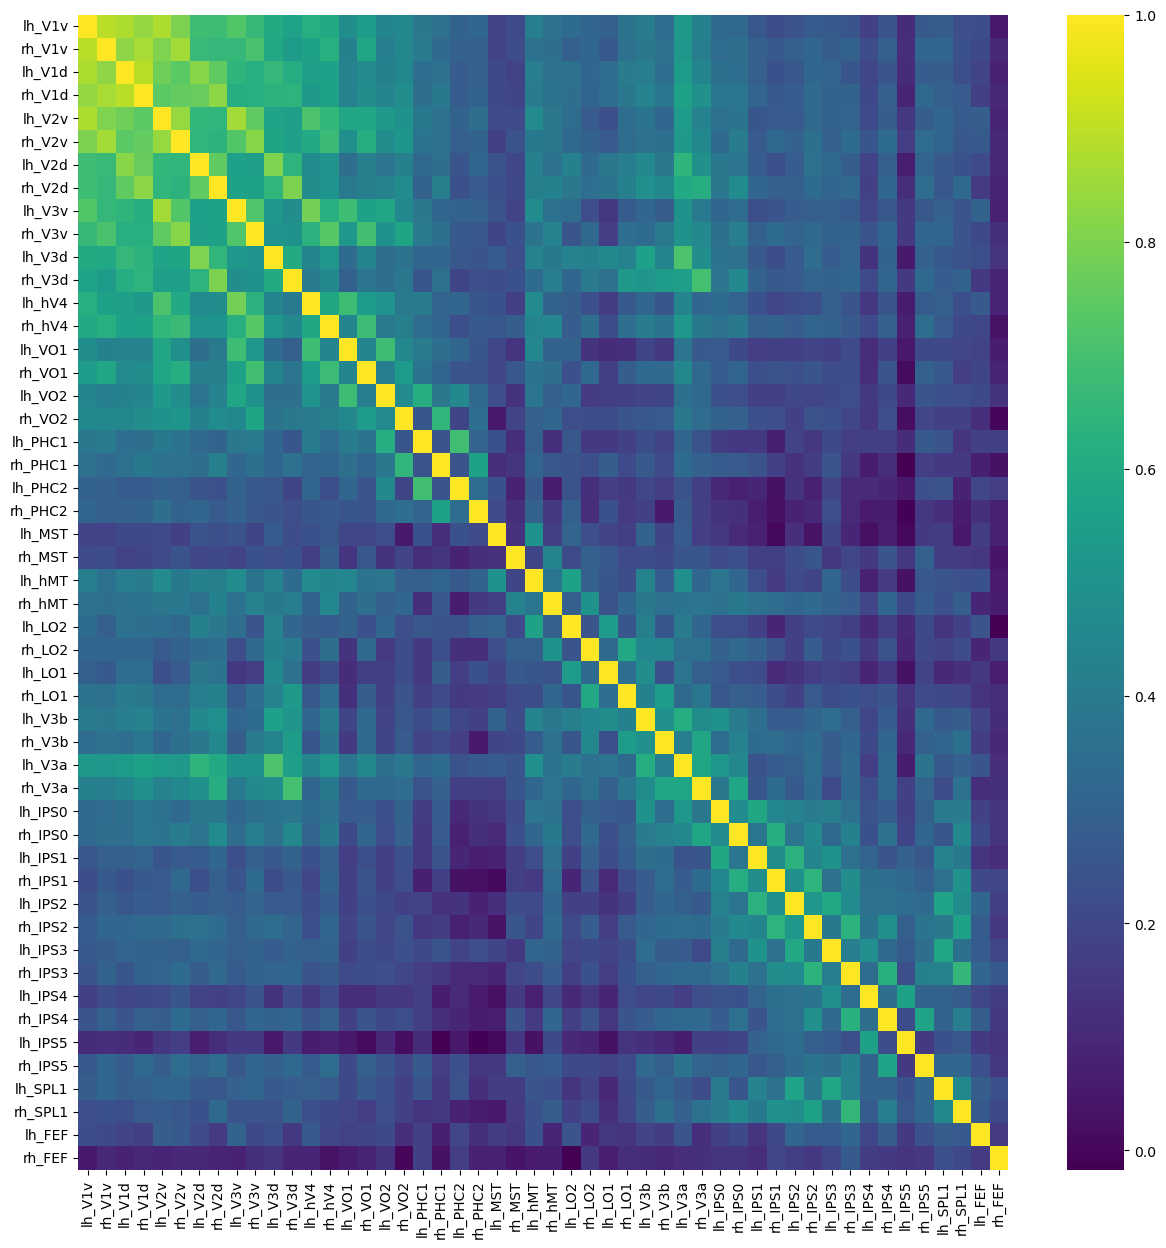

In [48]:
#Extract infant data
infant_list = pd.read_csv(f'{infant_dir}/participants.csv')
infant_list = infant_list.head(30)

infant_fc = compute_group_fc(infant_list, f'{infant_dir}/derivatives/fc_matrix', atlas = 'wang')

#vectorize fc matrix
infant_vec = infant_fc[np.triu_indices_from(infant_fc, k = 1)]


#plot
plot_fc_matrix(infant_fc,all_labels)

#Extract adult data
adult_list = pd.read_csv(f'{adult_dir}/participants.csv')
adult_list = adult_list.head(30)

adult_fc = compute_group_fc(adult_list, f'{adult_dir}/derivatives/fc_matrix', atlas = 'wang')
#vectorize fc matrix
adult_vec = adult_fc[np.triu_indices_from(adult_fc, k = 1)]

plot_fc_matrix(adult_fc,all_labels)



In [49]:
#set diagonal to nan
np.fill_diagonal(adult_fc, np.nan)
np.fill_diagonal(infant_fc, np.nan)

#convert to pandas dataframe and melt
adult_df = pd.DataFrame(adult_fc, index = all_labels, columns = all_labels)
adult_df = pd.melt(adult_df, var_name ='roi',value_name='corr')
adult_df = adult_df.dropna()

infant_df = pd.DataFrame(infant_fc, index = all_labels, columns = all_labels)
infant_df = pd.melt(infant_df, var_name ='roi',value_name='corr')
infant_df = infant_df.dropna()

full_df = pd.DataFrame()



In [50]:

#combine dataframes
full_df['adult'] = adult_df['corr']
full_df['infant'] = infant_df['corr']
full_df['roi'] = adult_df['roi']

#add columns for network
for roi in full_df['roi']:
    #find index of roi in all_labels
    idx = all_labels.index(roi)
    #get network
    network = all_networks[idx]
    #add to dataframe
    full_df.loc[full_df['roi'] == roi, 'network'] = network


/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning

<Axes: xlabel='roi'>

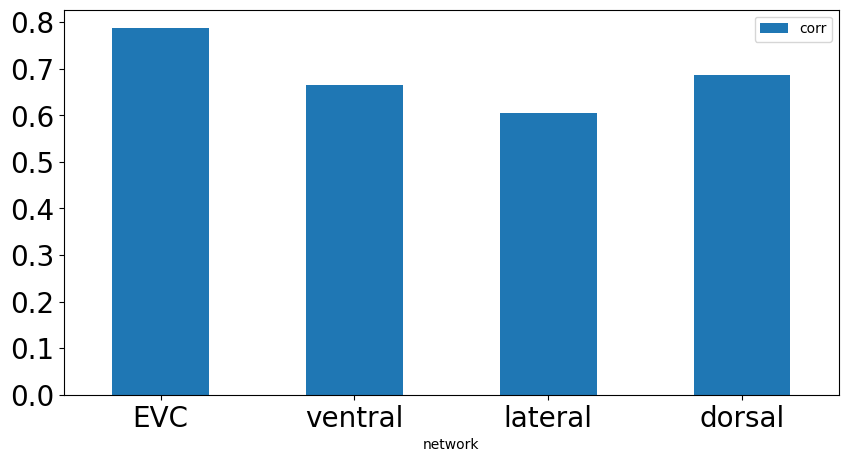

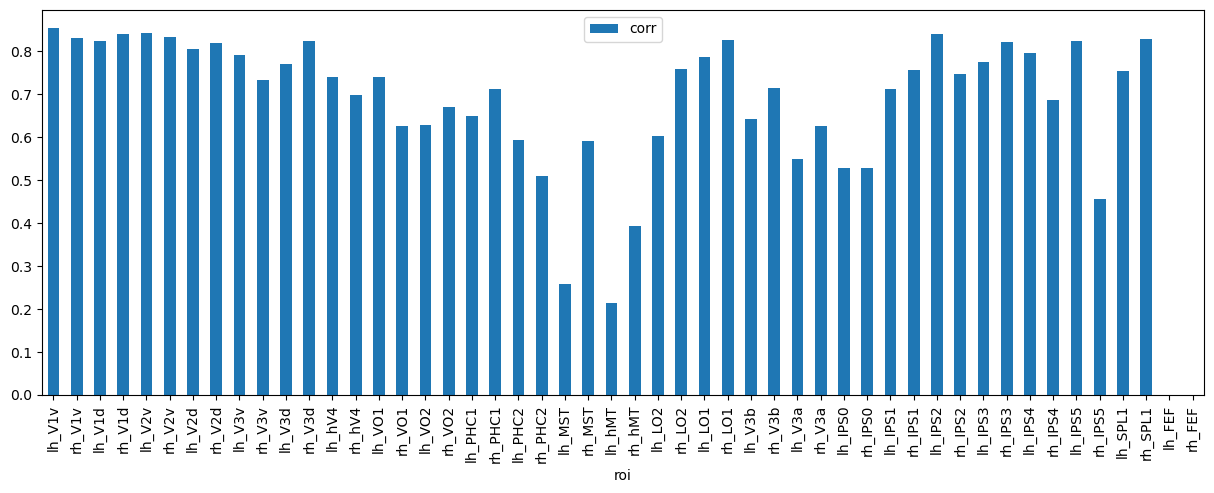

In [53]:
#remove lh_FEF and rh_FEF from full_df
full_df = full_df[full_df['roi'] != 'rh_FEF']
full_df = full_df[full_df['roi'] != 'lh_FEF']


#loop through networks and compute correlation between infants and adults
network_summary = pd.DataFrame(columns = ['network', 'corr'])
for net in networks:
    #Extract values for network
    curr_vals = full_df[full_df['network'] == net]

    #compute correlation between infants and adults
    corr= np.corrcoef(curr_vals['adult'], curr_vals['infant'])[0,1]

    #concat to summary df
    network_summary = pd.concat([network_summary, pd.DataFrame({'network': net, 'corr': corr}, index = [0])], ignore_index = True)

network_summary.plot.bar(x = 'network', y = 'corr', rot = 0, figsize = (10,5), fontsize = 20)


#loop through ROIs and compute correlation between infants and adults
roi_summary = pd.DataFrame(columns = ['roi', 'corr'])
for roi in all_labels:
    #Extract values for network
    curr_vals = full_df[full_df['roi'] == roi]

    #compute correlation between infants and adults
    corr= np.corrcoef(curr_vals['adult'], curr_vals['infant'])[0,1]

    #concat to summary df
    roi_summary = pd.concat([roi_summary, pd.DataFrame({'roi': roi, 'corr': corr}, index = [0])], ignore_index = True)

roi_summary.plot.bar(x = 'roi', y = 'corr', rot = 90, figsize = (15,5), fontsize = 10)



<Axes: title={'center': 'Network Summary'}>

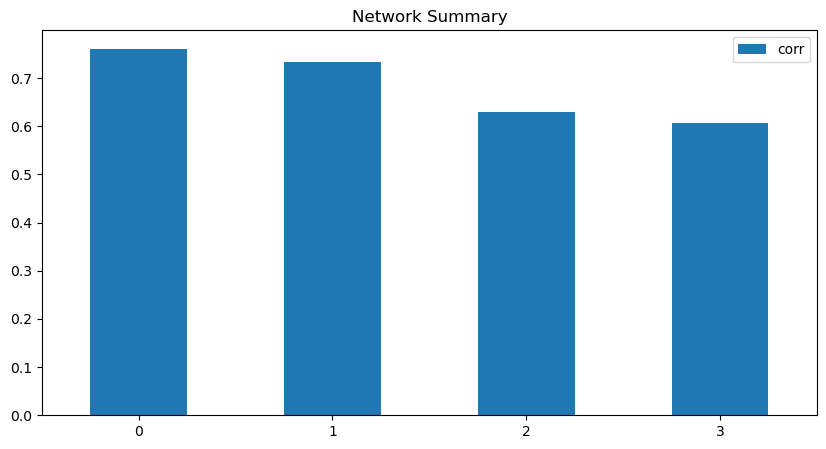

In [33]:
network_summary.plot(kind='bar', figsize=(10, 5), rot=0, title='Network Summary')

In [15]:
#extract and label each value in matrix by label
label_mat = np.zeros(corr_mat.shape)
for i in range(len(roi_labels)):
    for j in range(len(roi_labels)):
        corr_mat[i,j] = f'{roi_labels["label"][i]}_{roi_labels["label"][j]}'

array([[1.       , 0.6094827],
       [0.6094827, 1.       ]])

In [21]:
#save mean_fc as csv 
#convert to dataframe
mean_fc_df = pd.DataFrame(mean_fc)
mean_fc_df.to_csv('mean_fc.csv', index=False, header=False)


### Visualize correlation matrix

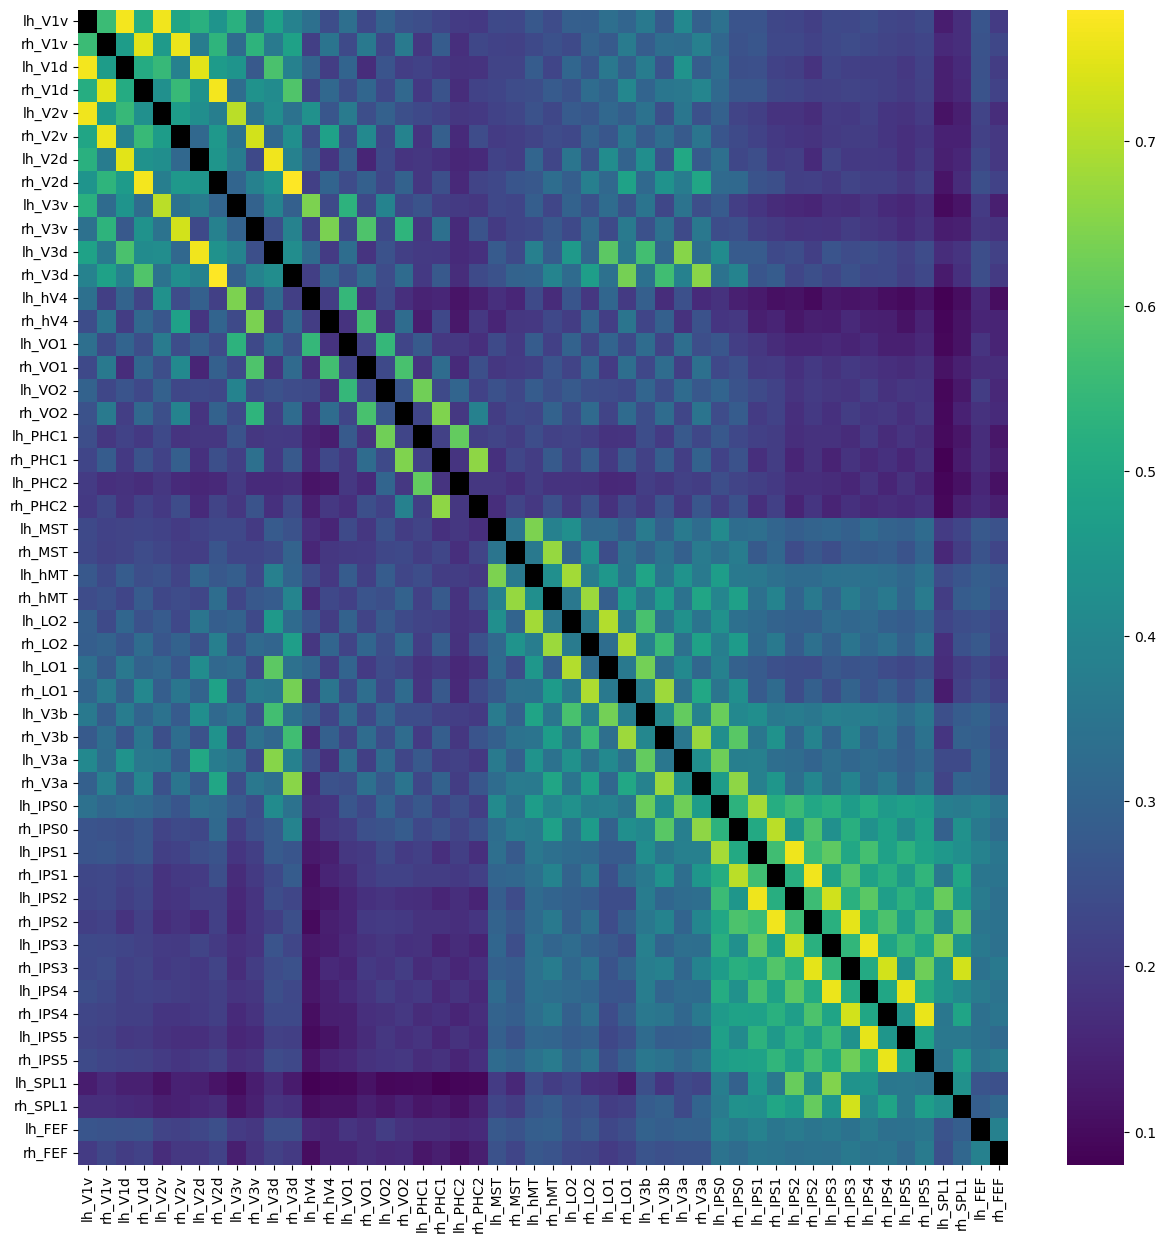

/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0, 0.5, 'MDS dimension 2')

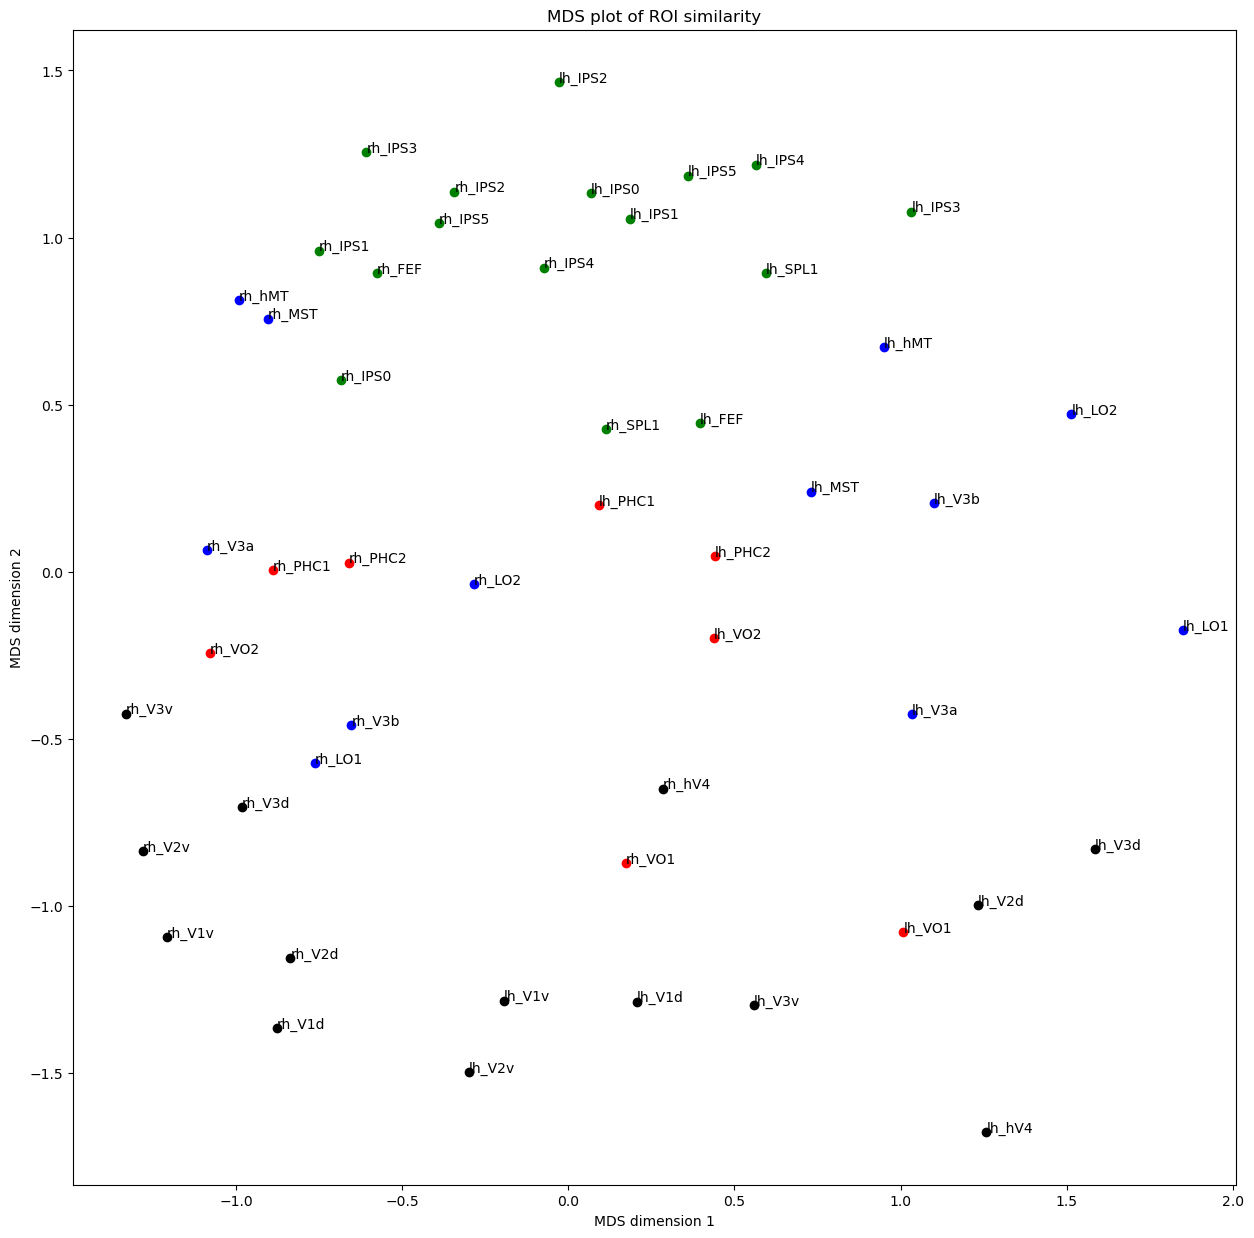

In [29]:
#plot mds results
#plt.scatter(mds_results[:,0], mds_results[:,1])

#run MDS on fc matrix
mds = MDS(n_components = 2)
mds_results = mds.fit(fc_mat).embedding_

for i, net_id in enumerate(all_networks):
    plt.scatter(mds_results[i,0], mds_results[i,1], c = network_colors[networks.index(net_id)], label = net_id)

#add labels
for i, label in enumerate(all_labels):
    plt.annotate(label, (mds_results[i,0], mds_results[i,1]) )

#color code points by network and network_color
for i, net in enumerate(networks):
    plt.scatter(mds_results[networks==net,0], mds_results[networks==net,1], c = network_colors[i], label = net)

#add lines between points

#make plot larger
plt.rcParams['figure.figsize'] = [15, 15]
plt.title('MDS plot of ROI similarity')
plt.xlabel('MDS dimension 1')
plt.ylabel('MDS dimension 2')



In [27]:
#save all labels
#convert all labels to dataframe
label_df = pd.DataFrame(np.asanyarray(all_labels))
#save
label_df.to_csv('labels.csv', index=False, header=False)